In [1]:
import gdsfactory as gf
import meep as mp
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import random

Using MPI version 4.1, 1 processes


In [17]:
def waveguide(l, w, ly):
  xs = gf.cross_section.strip(width = w, layer = [ly, 0])
  return gf.components.straight(length = l, cross_section=xs)

def waveguide_antenna(wg, h):
  
  w0 = 1  #substrate
  w1 = 3  # sio2
  w2 = wg  #si waeguide  500 nm = 0.5
  n_periods, period, duty_cycle, grating_height = 10, 0.63, 0.5 ,h
  idx = random.random()
  c = gf.Component()

  l = period * n_periods+2
  
  l0 = c << waveguide(l, w0, 1)
  l0.move((0, w0/2))
  l1 = c << waveguide(l, w1, 2)
  l1.move((0,w0+w1/2))
  l2 = c << waveguide(l, w2, 3)
  l2.move((0, w0+ w1 + w2/2))

  for i in range(n_periods):
        tooth = c << waveguide(
        l = period * duty_cycle,
        w=grating_height,
        ly=4
        )
        x_position = c.xsize/2 -l/2 + 1 + i * period + (period * (1 - duty_cycle) / 2)
        tooth.move(( x_position, w0+w1+w2+grating_height/2))
        
  c.flatten()


  gdsII_file= "/home/reema/Desktop/PIC/grating_coupler_"+str(idx)+".gds"

  c.write_gds(gdsII_file)
  return c.xsize, c.ysize, gdsII_file




In [18]:

def simulation(sim, phis, thetas,fcen, npts, sx, sy, sz, dpml, dair,r, case):
    nearfield = sim.add_near2far(fcen, 0, 1, mp.Near2FarRegion(mp.Vector3(0,0.5*sy-dpml-2.5*dair,0), size=mp.Vector3(sx-2*dpml, 0, sz-2*dpml)))

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(), 1e-3))
    
    angles = phis

    E = np.zeros((npts,3),dtype=np.complex128)
    H = np.zeros((npts,3),dtype=np.complex128)
    for n in range(npts):
        ff = sim.get_farfield(nearfield,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n]),0))
        E[n,:] = [ff[j] for j in range(3)]
        H[n,:] = [ff[j+3] for j in range(3)]
    
    Px = np.real(np.conj(E[:, 1]) * H[:, 2] - np.conj(E[:, 2]) * H[:, 1])
    Py = np.real(np.conj(E[:, 2]) * H[:, 0] - np.conj(E[:, 0]) * H[:, 2])
    Pz = np.real(np.conj(E[:, 0]) * H[:, 1] - np.conj(E[:, 1]) * H[:, 0])
    Pr = np.sqrt(np.square(Px) + np.square(Pz))
    Pr = Pr/np.max(Pr)
    idx = np.where((phis > np.deg2rad(45)) & (phis < np.deg2rad(70)))
    sPr = Pr[idx]
    val = (np.sum(sPr))/(np.sum(Pr))
    
    if(case == 'plot'):
        ax = plt.subplot(111, projection='polar')
        ax.plot(angles,Pr,'bo-')
        ax.set_rmax(1)
        ax.set_rticks([0,0.5,1])
        ax.grid(True)
        ax.set_rlabel_position(22)
        plt.show()
    
    return Pr


def setup(wg, h, case):
    grid_step = 0.002  # example resolution unit
    wg = round(wg / grid_step) * grid_step
    h = round(h / grid_step) * grid_step
    # p = round(p / grid_step) * grid_step
    # d = round(d / grid_step) * grid_step

    
    dpml = 1.0
    dair = 1

    t_si3n4 = 1
    t_si = 0.45
    t_sio2 = 3*(t_si3n4)
    t_sub = t_sio2
    
    resolution = 10


    si = mp.Medium(index=3.6)
    sio2 = mp.Medium(index=1.44)
    si3n4 = mp.Medium(index=2.0)

    wvl = 1.55
    fcen = 1 / wvl
    width = 0.1
    fwidth = width * fcen

    src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)

    r = 1000/fcen  # 1000 wavelengths out from the source
    npts = 100  # number of points in [0,2*pi) range of angles
    # define field projection angle ranges
    thetas = np.linspace(0, np.pi/3, npts)  # polar angle
    phis = np.linspace(0, 2*np.pi, npts)  # azimuthal angle
  
    l_g, w, gdsII_file = waveguide_antenna(wg, h)

    geometry = (
        mp.get_GDSII_prisms(si3n4, gdsII_file, 4, -t_si3n4/2, t_si3n4/2)+
        mp.get_GDSII_prisms(si, gdsII_file, 3, -t_si/2, t_si/2) +
        mp.get_GDSII_prisms(sio2, gdsII_file, 2, -t_sio2/2, t_sio2/2) +
        mp.get_GDSII_prisms(si, gdsII_file, 1, -t_sub/2, t_sub/2)
    
    )
    sx, sy, sz = l_g + 2 * dpml, w + 2 * dpml + 3.5 * dair, t_sub + 2 * dpml
    cell = mp.Vector3(sx, sy, sz)

    for g in geometry:
        #w0+w1 = 4

        g.center -= mp.Vector3(l_g/2, 4, 0)
        
    #define the source
    #size = (0, waveguide width, 0)
    sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen, fwidth=0.2*fcen),
                                size=mp.Vector3(0,wg,t_sub),
                                center=mp.Vector3(-0.5*sx + dpml,wg/2,0),
                                eig_match_freq=True,
                                eig_parity=mp.ODD_Y)]

    # Use PML boundary layers on all sides
    pml_layers = [mp.PML(dpml)]
    
    # Create simulation object
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=sources,
        resolution=resolution,
        dimensions=3
    )
    #to visualize the setup
    val = simulation(sim, phis, thetas,fcen, npts, sx, sy, sz, dpml, dair, r, case)
    os.remove(gdsII_file)
    return val

def main(input, grad):
    mp.verbosity(0)
    try:
        wg = input[0]
        h = input[1]
        # p = input[2]
        # d = input[3]
        val = setup(wg, h, "noplot")
        print(f"Evaluated at wg={wg}, h={h}, val={val}")
        
        return val
    except Exception as e:
        print(f"Error during evaluation: {e}")
        # Return a very low value so NLopt avoids this area
        return 1e-6

    return val

# main([0.3, 0.5])

Evaluated at wg=0.7618116465110611, h=1.2521018232424321, val=0.2920110502867872


Evaluated at wg=0.8018116465110612, h=1.2521018232424321, val=0.13015228809822402


Evaluated at wg=0.7618116465110611, h=1.2921018232424322, val=0.28327688505853205


Evaluated at wg=0.7218116465110611, h=1.2521018232424321, val=0.23513204845930336


Evaluated at wg=0.7618116465110611, h=1.212101823242432, val=0.2971288691605951


Evaluated at wg=0.7522129600809139, h=1.175494204699322, val=0.31045117927287735


Evaluated at wg=0.7480844234743556, h=1.0999166600725154, val=0.17522283113697415


Evaluated at wg=0.7539694274416958, h=1.2154556213710381, val=0.3064046809154157


Evaluated at wg=0.7475002755262681, h=1.1932973124690591, val=0.1523328715354088
optimum at wg=0.7522129600809139 um, h=1.175494204699322 um 
maximum value = 0.31045117927287735
result code = 1


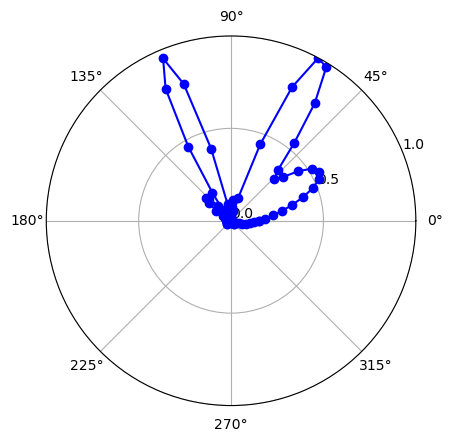

In [6]:
import nlopt
import random
# lattice parameter (um)
wg_min = 0.2
wg_max = 1

# waveguide width (fraction of lattice parameter)
h_min = 0.2
h_max = 2

# d_min = 0.5
# d_max = 1

# p_min = 0.5
# p_max = 1

opt = nlopt.opt(nlopt.LN_BOBYQA, 2)
opt.set_max_objective(main)
opt.set_lower_bounds([ wg_min, h_min])
opt.set_upper_bounds([ wg_max, h_max])
opt.set_ftol_abs(0.005)
opt.set_xtol_abs(0.02)
opt.set_initial_step(0.04)
opt.max_eval = 50

# random initial parameters
wg_0 = wg_min + (wg_max-wg_min)*random.random()  # rounded to 2nm
h_0 = h_min + (h_max-h_min)*random.random()
# p_0 = p_min + (p_max-p_min)*random.random()  # rounded to 2nm
# d_0 = d_min + (d_max-d_min)*random.random()


x = opt.optimize([wg_0, h_0])
maxf = opt.last_optimum_value()
print("optimum at wg={} um, h={} um ".format(x[0],x[1]))
print("maximum value = {}".format(maxf))
print("result code = {}".format(opt.last_optimize_result()))
    
val = setup(x[0],x[1], "plot")

In [ ]:
def plot_radiation_pattern_3d(Ptheta):
    """Plots the radiation pattern in 3d Cartesian coordinates.

    Args:
        Ptheta: radial flux of the far fields in polar coordinates.
    """
    
    npts = 100  # number of points in [0,2*pi) range of angles
    # define field projection angle ranges
    thetas = np.linspace(0, np.pi/3, npts)  # polar angle
    phis = np.linspace(0, 2*np.pi, npts)  # azimuthal angle

    xs = np.zeros((len(thetas), len(phis)))
    ys = np.zeros((len(thetas), len(phis)))
    zs = np.zeros((len(thetas), len(phis)))

    for i, theta in enumerate(thetas):
        for j, phi in enumerate(phis):
            xs[i, j] = Ptheta[i] * np.sin(theta) * np.cos(phi)
            ys[i, j] = Ptheta[i] * np.sin(theta) * np.sin(phi)
            zs[i, j] = Ptheta[i] * np.cos(theta)

    
    # Plot with Plotly
    fig = go.Figure(data=[
        go.Surface(
            x=xs, y=ys, z=zs,
    
            colorscale='Viridis',
            cmin=0,
            cmax=1,
            showscale=True,
            opacity=1.0
        )
    ])

    fig.update_layout(
        title='3D Radiation Pattern (Plotly)',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
    )

    fig.show()
    
#0.75, 1.17 = 0.31
plot_radiation_pattern_3d(Pr)
